In [1]:
import pandas as pd

pop_df = pd.read_csv("data/Population Data.csv")
temp_df = pd.read_csv("data/Temperature Data.csv")

temp_df.name.replace({"Chicago O'Hare": "Chicago",
"Detroit/Wayne": "Detroit", 
"NYC/LaGuardia": "New York",
"Phoenix/Sky HRBR": "Phoenix",
"Sacramento/Execu": "Sacramento",
"St Louis/Lambert": "St. Louis",
"Wash DC/Dulles": "Washington",
}, inplace=True)
temp_df.location_date = pd.to_datetime(temp_df.location_date)

### Augment Population dataset with misssing cities

In [2]:
raleigh_durnham_pop = pop_df.loc[pop_df.City=="Raleigh", "population"].iloc[0] + pop_df.loc[pop_df.City=="Durham", "population"].iloc[0]
raleigh_durnham_lon = (pop_df.loc[pop_df.City=="Raleigh", "Lon"].iloc[0] + pop_df.loc[pop_df.City=="Durham", "Lon"].iloc[0])/2
raleigh_durnham_lat = (pop_df.loc[pop_df.City=="Raleigh", "Lat"].iloc[0] + pop_df.loc[pop_df.City=="Durham", "Lat"].iloc[0])/2

pop_df = pop_df.append({"City": "Raleigh/Durham", 
               "State": "North Carolina", 
               "population": raleigh_durnham_pop,
               "Lon": raleigh_durnham_lon,
               "Lat":raleigh_durnham_lat
              }, ignore_index=True)

pop_df= pop_df.append({"City": "Albany", 
               "State": "New York", 
               "population": 97856, # taken from wikipedia
               "Lon": -73.7562,
               "Lat":42.6526
              }, ignore_index=True)
pop_df = pop_df.append({"City": "Windsor Locks", 
               "State": "Connecticut", 
               "population": 12876, # taken from wikipedia
               "Lon": -72.6454,
               "Lat":41.9243
              }, ignore_index=True)
pop_df = pop_df.append({"City": "Covington", 
               "State": "Georgia", 
               "population":13967, # taken from wikipedia
               "Lon": -84.50855,
               "Lat":39.08367
              }, ignore_index=True)

# remove columbus georgia and richmond california
pop_df = pop_df[~((pop_df.City == "Columbus")&(pop_df.State == "Georgia"))&~((pop_df.City == "Richmond")&(pop_df.State == "California"))]

<AxesSubplot:xlabel='location_date', ylabel='temp_mean_c'>

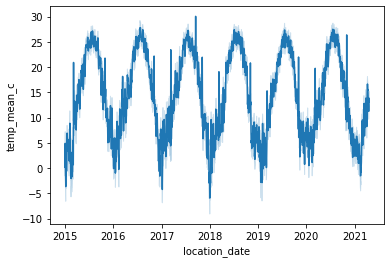

In [3]:
import seaborn as sns

sns.lineplot(data=temp_df, x="location_date", y="temp_mean_c")

### Combine Portland stations KPDX and KPWM

In [4]:
combine_portland_stations = temp_df[temp_df.name=="Portland"].groupby("location_date").agg({"temp_mean_c": "mean", "temp_min_c": "mean", "temp_max_c": "mean"}).reset_index()
combine_portland_stations["name"] = "Portland"
combine_portland_stations["country_name"] = "UnitedStates"
combine_portland_stations["country_code"] = "USA"
combine_portland_stations["continent"] = "North America"
combine_portland_stations["station_code"] = "KPDX|KPWM"

temp_df = temp_df[temp_df["name"]!="Portland"]
temp_df = pd.concat([temp_df, combine_portland_stations])

In [5]:
temp_df

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c
0,Atlanta,UnitedStates,USA,North America,KATL,2021-04-20,17.491667,12.20,23.30
1,Windsor Locks,UnitedStates,USA,North America,KBDL,2021-04-20,13.887500,3.90,22.20
2,Nashville,UnitedStates,USA,North America,KBNA,2021-04-20,15.175000,6.70,23.30
3,Boise,UnitedStates,USA,North America,KBOI,2021-04-20,9.329167,1.70,15.60
4,Boston,UnitedStates,USA,North America,KBOS,2021-04-20,16.716667,10.00,23.90
...,...,...,...,...,...,...,...,...,...
2283,Portland,UnitedStates,USA,North America,KPDX|KPWM,2021-04-16,10.618750,5.00,16.10
2284,Portland,UnitedStates,USA,North America,KPDX|KPWM,2021-04-17,11.672917,5.30,18.60
2285,Portland,UnitedStates,USA,North America,KPDX|KPWM,2021-04-18,13.087500,6.65,19.70
2286,Portland,UnitedStates,USA,North America,KPDX|KPWM,2021-04-19,12.587500,5.85,18.90


In [6]:
temp_df = temp_df.merge(pop_df, how="left", left_on="name", right_on="City")

In [7]:
from datetime import timedelta

def preprocess_missing_temperatures(temp_df: pd.DataFrame)->pd.DataFrame:
    """
    Creates a dataframe with records from missing days and
    fills temperature values with average of previous and 
    subsequent day. Merges with original dataframe.
    """
    temp_df['filled'] = 0
    orig_cols = list(temp_df)
    
    temp_df['location_date'] = pd.to_datetime(temp_df['location_date'])
    temp_df = temp_df.sort_values(['station_code', 'location_date'], ascending=True).reset_index(drop=True)
    
    temp_df['prev_d'] = temp_df['location_date'].shift(1)
    temp_df['t_diff'] = temp_df['location_date'] - temp_df['prev_d']
    temp_df['t_diff'] = temp_df['t_diff'].apply(lambda x: x.days)
    for col in ['temp_mean_c', 'temp_min_c', 'temp_max_c']:
        temp_df['prev_'+col] = temp_df[col].shift(1)
    
    missing = temp_df.loc[temp_df['t_diff']>1.0].copy()
    missing['location_date'] = missing['location_date'].apply(lambda x: x+timedelta(days=-1))
    for col in ['temp_mean_c', 'temp_min_c', 'temp_max_c']:
        missing[col] = missing[[col, 'prev_'+col]].mean(axis=1)
        
    missing['filled'] = 1
        
    return pd.concat([temp_df[orig_cols], missing[orig_cols]]).sort_values(['station_code', 'location_date'], ascending=True).reset_index(drop=True)

In [8]:
temp_df = preprocess_missing_temperatures(temp_df)

In [9]:
total_pop = temp_df.groupby("name").population.first().sum()
temp_df["population_weight"] = temp_df.population / total_pop

In [10]:
temp_df

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c,City,State,population,Lon,Lat,filled,population_weight
0,Albany,UnitedStates,USA,North America,KALB,2015-01-01,-3.362500,-7.2,0.0,Albany,New York,97856,-73.7562,42.6526,0,0.002883
1,Albany,UnitedStates,USA,North America,KALB,2015-01-02,-0.683333,-3.3,1.7,Albany,New York,97856,-73.7562,42.6526,0,0.002883
2,Albany,UnitedStates,USA,North America,KALB,2015-01-03,-3.545833,-6.7,0.6,Albany,New York,97856,-73.7562,42.6526,0,0.002883
3,Albany,UnitedStates,USA,North America,KALB,2015-01-04,4.166667,0.6,6.7,Albany,New York,97856,-73.7562,42.6526,0,0.002883
4,Albany,UnitedStates,USA,North America,KALB,2015-01-05,-4.654167,-10.6,4.4,Albany,New York,97856,-73.7562,42.6526,0,0.002883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87470,St. Louis,UnitedStates,USA,North America,KSTL,2021-04-16,11.100000,6.7,15.0,St. Louis,Missouri,318069,-90.2446,38.6357,0,0.009371
87471,St. Louis,UnitedStates,USA,North America,KSTL,2021-04-17,11.458333,8.9,15.6,St. Louis,Missouri,318069,-90.2446,38.6357,0,0.009371
87472,St. Louis,UnitedStates,USA,North America,KSTL,2021-04-18,12.691667,7.8,18.3,St. Louis,Missouri,318069,-90.2446,38.6357,0,0.009371
87473,St. Louis,UnitedStates,USA,North America,KSTL,2021-04-19,13.054167,6.7,21.1,St. Louis,Missouri,318069,-90.2446,38.6357,0,0.009371


In [11]:
def weighted_mean_function(column="temp_mean_c"):
    def weighted_mean(rows):
        return (rows.population_weight * rows[column]).sum() / len(rows.location_date.unique())
    return weighted_mean

month_mean = temp_df.groupby(pd.Grouper(key="location_date", freq="1M")).apply(weighted_mean_function()).reset_index(name='weighted_mean_temp')
month_min = temp_df.groupby(pd.Grouper(key="location_date", freq="1M")).apply(weighted_mean_function("temp_min_c")).reset_index(name='weighted_min_temp')
month_max = temp_df.groupby(pd.Grouper(key="location_date", freq="1M")).apply(weighted_mean_function("temp_max_c")).reset_index(name='weighted_max_temp')

### Someone who wants to view monthly min/max/mean

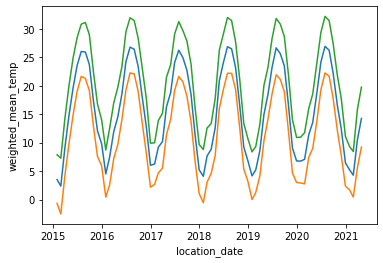

In [12]:
import matplotlib.pyplot as plt

sns.lineplot(data=month_mean, x="location_date", y="weighted_mean_temp")
sns.lineplot(data=month_min, x="location_date", y="weighted_min_temp")
sns.lineplot(data=month_max, x="location_date", y="weighted_max_temp")

plt.show()

In [14]:
temp_df[["name", "station_code", "population", "location_date", "temp_mean_c", "temp_min_c", "temp_max_c", "filled", "population_weight", "Lon", "Lat"]].to_csv("processed_temp_df.csv", index=False)

In [15]:
month_mean = temp_df.groupby(pd.Grouper(key="location_date", freq="1D")).apply(weighted_mean_function()).reset_index(name='weighted_mean_temp')
month_min = temp_df.groupby(pd.Grouper(key="location_date", freq="1D")).apply(weighted_mean_function("temp_min_c")).reset_index(name='weighted_min_temp')
month_max = temp_df.groupby(pd.Grouper(key="location_date", freq="1D")).apply(weighted_mean_function("temp_max_c")).reset_index(name='weighted_max_temp')
df = month_mean.merge(month_min, on="location_date").merge(month_max, on="location_date")
df.to_csv("daily_weighted_temperatures.csv", index=False)